In [1]:
import os
import os.path as osp
import sys
import numpy as np
from pprint import pprint

# add matplotlib before cv2, otherwise bug
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 10.0)

# add  
sys.path.insert(0, '../lib')
from roi_data_layer.layer import RoIDataLayer
from datasets import refer_loader
from layer_utils.proposal_target_layer import proposal_target_layer
from utils.mask_utils import decode
from model.config import cfg
cfg.TRAIN.BATCH_SIZE = 12
cfg.TRAIN.BBOX_NORMALIZE_TARGETS_PRECOMPUTED = True

# torch
import torch
from torch.autograd import Variable

In [2]:
# visualize
def vis_pos(loader, im_data, labels, boxes, masks=None):
    PIXEL_MEANS = np.array([[[102.9801, 115.9465, 122.7717]]])
    im_data += PIXEL_MEANS
    im_data[:,:,:] = im_data[:,:,[2,1,0]]
    im_data = im_data.astype(np.uint8)
    plt.imshow(im_data)
    num_anns = labels.shape[0]
    NPs = loader.decode_labels(labels)
    ax = plt.gca()
    for ix in range(num_anns):
        if masks is not None:
            # add mask
            m = masks[ix]/255.  # float32 ranging [0,1]
            color_mask = np.random.random((1,3)).tolist()[0]
            img = np.ones( (m.shape[0], m.shape[1], 3) )
            for i in range(3):
                img[:, :, i] = color_mask[i]
            ax.imshow(np.dstack( (img, m*0.2) ))
        # add box and label
        box = boxes[ix] # uint8 (x1y1x2y2)
        x1 = int(round(box[0]))
        y1 = int(round(box[1]))
        x2  = int(round(box[2]))
        y2  = int(round(box[3]))
        display_txt = NPs[ix]
        coords = (x1, y1), x2-x1+1, y2-y1+1
        ax.add_patch(plt.Rectangle(*coords, fill=False, edgecolor='green', linewidth=2))
        ax.text(x1, y1, display_txt, bbox={'facecolor':'green', 'alpha':0.5})
    return ax

def vis_neg(loader, im_data, labels, boxes):
    PIXEL_MEANS = np.array([[[102.9801, 115.9465, 122.7717]]])
    im_data += PIXEL_MEANS
    im_data[:,:,:] = im_data[:,:,[2,1,0]]
    im_data = im_data.astype(np.uint8)
    plt.imshow(im_data)
    num_anns = labels.shape[0]
    NPs = loader.decode_labels(labels)
    ax = plt.gca()
    for ix in range(num_anns):
        # add box and label
        box = boxes[ix] # uint8 (x1y1x2y2)
        x1 = int(round(box[0]))
        y1 = int(round(box[1]))
        x2  = int(round(box[2]))
        y2  = int(round(box[3]))
        display_txt = NPs[ix]
        coords = (x1, y1), x2-x1+1, y2-y1+1
        ax.add_patch(plt.Rectangle(*coords, fill=False, edgecolor='red', linewidth=2))
        ax.text(x1, y1, display_txt, bbox={'facecolor':'red', 'alpha':0.5})

In [3]:
# refer loader
loader = refer_loader.loader(dataset='refcoco', splitBy='unc')
# append flipped
print('Appending horizontally-flipped training examples...')
loader.append_flipped_images('train')
print('done')
# Layer
data_layer = RoIDataLayer(loader, ['train', 'val'], 'NN')

info read from /mnt/ilcompf6d0/user/liyu/Documents/work/refer_adobe/faster-rcnn/find-mask-rcnn/data/cache/refcoco_unc/data.json in 7.65 seconds.
vocab size is  1999
We have 19994 images, 196771 anns, 50000 refs.
object category size is  81
We have 299048 NPs (max_NP_length=5) for 196771 anns.
We have 290168 NNs (max_NN_length=3) for 196771 anns.
assigned 750 images to split testA.
assigned 16994 images to split train.
assigned 1500 images to split val.
assigned 750 images to split testB.
gt_roidb loaded from /mnt/ilcompf6d0/user/liyu/Documents/work/refer_adobe/faster-rcnn/find-mask-rcnn/data/cache/refcoco_unc/gt_roidb.pkl in 3.09 seconds
Appending horizontally-flipped training examples...
done


In [13]:
# get one batch
blobs = data_layer.forward()
print(blobs.keys())
print(blobs['gt_boxes'].shape)

['neg_labels', 'im_info', 'gt_labels', 'num_labels', 'bg_labels', 'gt_boxes', 'data', 'gt_masks']
(6, 5)


In [14]:
# Fake some inputs
num_rpn_rois = min(3, blobs['gt_boxes'].shape[0])
rpn_rois = np.hstack([np.zeros((num_rpn_rois, 1)),
                      blobs['gt_boxes'][:num_rpn_rois, :4]]).astype(np.float32) # float (N, 5) [0xyxy]
rpn_rois = np.vstack([rpn_rois, 
                      np.hstack([np.zeros((num_rpn_rois, 1)), rpn_rois[:, 1:]+100.0])]).astype(np.float32)

gt_boxes = blobs['gt_boxes']   # (M, 5) [xyxycls]
gt_labels = blobs['gt_labels'] # (M, L)
neg_labels = blobs['neg_labels'] # (M, 80, L)
bg_labels = blobs['bg_labels'] # (81, L)
gt_masks = blobs['gt_masks']# uint8 [0, 1]

In [15]:
# move to gpu Variable
rpn_rois = Variable(torch.from_numpy(rpn_rois).cuda())
gt_boxes = Variable(torch.from_numpy(gt_boxes).float().cuda())
gt_labels = Variable(torch.from_numpy(gt_labels).cuda())
neg_labels = Variable(torch.from_numpy(neg_labels).cuda())
bg_labels = Variable(torch.from_numpy(bg_labels).cuda())

In [16]:
# run proposal_target_layer
rois, me_inds, me_labels, me_targets, bc_inds, bc_labels, bc_targets, \
bbox_targets, bbox_inside_weights, bbox_outside_weights, mask_targets, num_pos_rois = \
    proposal_target_layer(rpn_rois, gt_boxes, gt_labels, neg_labels, bg_labels, gt_masks)

## ME: show (me_rois, me_labels, me_targets)

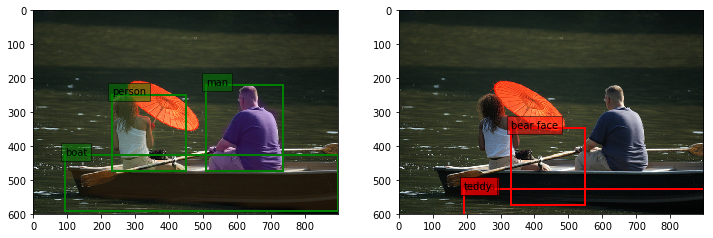

In [26]:
imh, imw = int(blobs['im_info'][0][0]), int(blobs['im_info'][0][1])
me_rois = rois[me_inds].data.cpu().numpy()
plt.show()
plt.subplot(121)
me_pos_bbox = me_rois[:num_pos_rois, 1:5]
me_pos_mask = decode(mask_targets.data.cpu().numpy(), me_pos_bbox, imh, imw, 'bilinear')
me_pos_labels = me_labels.data.cpu().numpy()[:num_pos_rois, 0, :]
vis_pos(loader, blobs['data'][0].copy(), me_pos_labels, me_pos_bbox, me_pos_mask)
plt.subplot(122)
me_neg_bbox = me_rois[num_pos_rois:, 1:5]
me_neg_labels = me_labels.data.cpu().numpy()[:num_pos_rois, 2, :]
vis_neg(loader, blobs['data'][0].copy(), me_neg_labels, me_neg_bbox)
plt.show()

# BC: show (bc_rois, bc_labels, bc_targets)

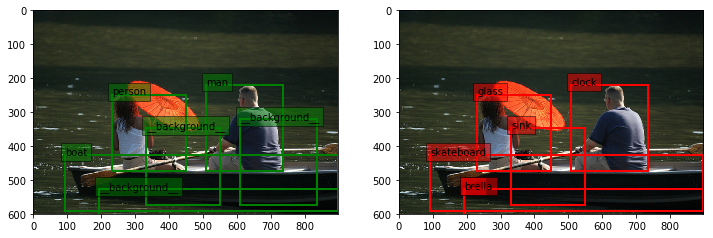

In [25]:
bc_rois = rois[bc_inds].data.cpu().numpy()
plt.show()
plt.subplot(121)
pos_inds = bc_targets.data.nonzero().cpu().view(-1).numpy()
bc_pos_bbox = bc_rois[pos_inds, 1:5]
bc_pos_labels = bc_labels.data.index_select(0, bc_targets.data.nonzero().view(-1)).cpu().numpy()
vis_pos(loader, blobs['data'][0].copy(), bc_pos_labels, bc_pos_bbox, None)
plt.subplot(122)
neg_inds = np.where(bc_targets.data.cpu().numpy() == 0)[0]
bc_neg_bbox = bc_rois[neg_inds, 1:5]
bc_neg_labels = bc_labels.data.cpu().index_select(0, torch.from_numpy(neg_inds)).numpy()
vis_neg(loader, blobs['data'][0].copy(), bc_neg_labels, bc_neg_bbox)
plt.show()

In [23]:
bc_inds


 0
 1
 2
 0
 1
 2
 3
 4
 5
 6
 7
 8
[torch.cuda.LongTensor of size 12 (GPU 0)]

In [24]:
me_inds


  0
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
[torch.cuda.LongTensor of size 12 (GPU 0)]

In [22]:
num_pos_rois

3

In [28]:
bc_targets

Variable containing:
 1
 1
 1
 0
 0
 0
 0
 0
 0
 1
 1
 1
[torch.cuda.DoubleTensor of size 12 (GPU 0)]